In [23]:
import torch
from torch import nn
from torch.utils import data
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Conv1d(channels, channels // reduction_ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv1d(channels // reduction_ratio, channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size % 2 == 1, "Kernel size must be odd"
        self.conv1 = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, spatial_kernel_size=3):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(spatial_kernel_size)

    def forward(self, x):
        x = self.channel_attention(x) * x
        x = self.spatial_attention(x) * x
        return x

class Conv_block(nn.Module):
    def __init__(self, in_channels,out_channels, use_1x1conv=False,stride=1,padding = 1):
        super(Conv_block, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding)
        self.ibn1 = nn.BatchNorm1d(out_channels)
    def forward(self, x):
        x = self.conv1(x)
        x = self.ibn1(x)
        x = F.relu(x)
        return x
class ca2_Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(ca2_Residual, self).__init__()

        self.Conv_block1 = Conv_block(in_channels=in_channels, out_channels=out_channels, stride=1,padding=1)
        self.Conv_block2 = Conv_block(in_channels=out_channels, out_channels=out_channels, stride=1,padding=1)
        self.conv1d_3 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1,padding=1)
        self.ibn_3 = nn.BatchNorm1d(out_channels)

        self.conv1_1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1)
        self.cbam = CBAM(in_channels=out_channels)
        
    def forward(self, x):
        y = self.Conv_block1(x)
        y = self.Conv_block2(y)
        y = self.ibn_3(self.conv1d_3(y))
        y = self.cbam(y)
        x = self.conv1_1(x)
        y =y+x
        end = F.relu(y)
        return end 
class ca2_resnet(nn.Module):
    def __init__(self):
        super(ca2_resnet, self).__init__()
        self.conv1 = Conv_block(in_channels=3, out_channels=8, stride=1)
        self.maxpool1 = nn.MaxPool1d(kernel_size=3,stride=1)

        self.caResnet1 = ca2_Residual(in_channels=8, out_channels=16, stride=1)
        self.caResnet2 = ca2_Residual(in_channels=16, out_channels=32, stride=1)
        self.caResnet3 = ca2_Residual(in_channels=32, out_channels=32, stride=1)
        self.caResnet4 = ca2_Residual(in_channels=32, out_channels=32, stride=1)

        self.Fl = nn.Flatten()
        self.mlp1 = nn.Sequential(
            nn.Linear(32*98, 256),
            nn.ReLU(),
            #nn.Dropout(p=0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 1),
            #nn.Softmax(dim=1)
            nn.Sigmoid()


        )
        self.mlp2 = nn.Sequential(
            nn.Linear(32*98, 256),
            nn.ReLU(),
            #nn.Dropout(p=0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256,2),

        )
        self.mlp3 = nn.Sequential(
            nn.Linear(32*98, 256),
            nn.ReLU(),
            #nn.Dropout(p=0.3),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256,2),

        )
        
    def forward(self, x):
  
        x = self.conv1(x)#
        x = self.maxpool1(x)
        x = self.caResnet1(x)
        x = self.caResnet2(x)
        x = self.caResnet3(x)
        x = self.caResnet4(x)
        x = self.Fl(x)
        x1 = self.mlp1(x)
        x2 = self.mlp2(x)
        x3 = self.mlp3(x)


        return x1,x2,x3
    
def test1(self, device,name, test_loader, myloss, batch_size,threshold):
    df_test= pd.DataFrame(columns=['targets',"preds","outputs","true_ew1","true_ew2","true_fwhm1","true_fwhm2","pre_ew1","pre_ew2","pre_fwhm1","pre_fwhm2","fitsname"]) 
    self.eval()
    true_labels_test1 = []
    predicted_labels_test1 = []
    outputs_list_test1 = []

    true_ew1_test1  = []
    true_ew2_test1  = []
    pre_ew1_test1  = []
    pre_ew2_test1 = []

    true_fwhm1_test1  = []
    true_fwhm2_test1  = []

    pre_fwhm1_test1  = []
    pre_fwhm2_test1  = []

    fitsname_test1  = []
    with torch.no_grad():
        for feature, label in test_loader:
            feature = feature.to(device)
            #feature = feature.unsqueeze(1)
            label = label.to(device)
            
            label_class = label[:,0:1]
            label_fitsname = label[:,1:2]
            label_ew1 = label[:,2:3]
            label_ew2 = label[:,3:4]
            label_fwhm1 = label[:,4:5]
            label_fwhm2 = label[:,5:6]
            outputs1,outputs2,outputs3 = self(feature) 
            
            outputs2_ew1 = outputs2[:,0:1]
            outputs2_ew2 = outputs2[:,1:2]
            outputs2_fwhm1 = outputs3[:,0:1]
            outputs2_fwhm2 = outputs3[:,1:2]

            predicted = (outputs1 >= threshold).float().detach().cpu().numpy()

            predicted_labels_test1.extend(predicted)
            true_labels_test1.extend(label_class.detach().cpu().numpy())
            outputs_list_test1.extend(outputs1.detach().cpu().numpy())
            true_ew1_test1.extend(label_ew1.detach().cpu().numpy())
            true_ew2_test1.extend(label_ew2.detach().cpu().numpy())
            pre_ew1_test1.extend(outputs2_ew1.detach().cpu().numpy())
            pre_ew2_test1.extend(outputs2_ew2.detach().cpu().numpy())
            true_fwhm1_test1.extend(label_fwhm1.detach().cpu().numpy())
            true_fwhm2_test1.extend(label_fwhm2.detach().cpu().numpy())
            pre_fwhm1_test1.extend(outputs2_fwhm1.detach().cpu().numpy())
            pre_fwhm2_test1.extend(outputs2_fwhm2.detach().cpu().numpy())
            fitsname_test1.extend(label_fitsname.detach().cpu().numpy())


    y_true = np.concatenate(true_labels_test1)
    y_pred = np.concatenate(predicted_labels_test1)
    out = np.concatenate(outputs_list_test1)
    true_ew1 = np.concatenate(true_ew1_test1)
    true_ew2 = np.concatenate(true_ew2_test1)
    pre_ew1 = np.concatenate(pre_ew1_test1)
    pre_ew2 = np.concatenate(pre_ew2_test1)
    true_fwhm1 = np.concatenate(true_fwhm1_test1)
    true_fwhm2 = np.concatenate(true_fwhm2_test1)
    pre_fwhm1 = np.concatenate(pre_fwhm1_test1)
    pre_fwhm2 = np.concatenate(pre_fwhm2_test1)
    fitsname = np.concatenate(fitsname_test1)

    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall    = recall_score(y_true, y_pred)
    f1        = f1_score(y_true, y_pred)
    beta = 0.5
    f2 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

    print(
        f'-real acc:{accuracy:6.4f},real pre:{precision:6.4f},real rec:{recall :6.4f},real f1:{f1 :6.4f},real f0.5:{f2 :6.4f}'
    )


    test_msgs={"targets":list(np.ravel(y_true)),
               "preds":list(np.ravel(y_pred)),
               "outputs":list(np.ravel(out)),
               "true_ew1":list(np.ravel(true_ew1)),
               "true_ew2":list(np.ravel(true_ew2)),
                "true_fwhm1":list(np.ravel(true_fwhm1)),
               "true_fwhm2":list(np.ravel(true_fwhm2)),
               "pre_ew1":list(np.ravel(pre_ew1)),
               "pre_ew2":list(np.ravel(pre_ew2)),

               "pre_fwhm1":list(np.ravel(pre_fwhm1)),
               "pre_fwhm2":list(np.ravel(pre_fwhm2)),
               "fitsname":list(np.ravel(fitsname)),
}
    test_csv_435=pd.DataFrame(test_msgs)

    return test_csv_435,accuracy,precision,recall,f1,f2

if __name__ == '__main__':

    batch_size = 256
    pd_435 = pd.read_csv("real_test_425.csv").drop(columns=['fitsname', 'qso'])
    pd_435 = np.array(pd_435)
    #pd_435=pd_435.dropna()
    df_435_x=pd_435[:,:300].reshape(-1, 3, 100)
    df_435_y=pd_435[:,300:306]
    print("test_435_shape:",df_435_x.shape,df_435_y.shape)
    x_435 = torch.from_numpy(df_435_x.astype(np.float32)).to(torch.float32)
    y_435 = torch.from_numpy(df_435_y.astype(np.float32)).to(torch.float32)
    test_loader_435 = data.DataLoader(data.TensorDataset(x_435, y_435), batch_size=batch_size)
    # cuda
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    threshold = 0.50

    net = ca2_resnet()

    net.load_state_dict(torch.load("net_cbam.pth"),strict=False)
    net.to(device)
    # 435
    print("\ntest435:")
    test_data_435,accuracy435,precision435,recall435,f1435,f2435=test1(net, device,"name", test_loader_435, "loss", batch_size,threshold)

    #  test_data_435 ，Pandas DataFrame
    count_1 = len(test_data_435[test_data_435['targets'] == 1])
    count_0 = len(test_data_435[test_data_435['targets'] == 0])
    count_435 = len(test_data_435[(test_data_435['targets'] == 1)&(test_data_435['outputs'] >0.5) ])
    print("class 0: ",count_0)
    print("class 1: ",count_1)
    print("TP: ",count_435)



test_435_shape: (425, 3, 100) (425, 6)

test435:
-real acc:0.9929,real pre:1.0000,real rec:0.9929,real f1:0.9965,real f0.5:0.9986
class 0:  0
class 1:  425
TP:  422


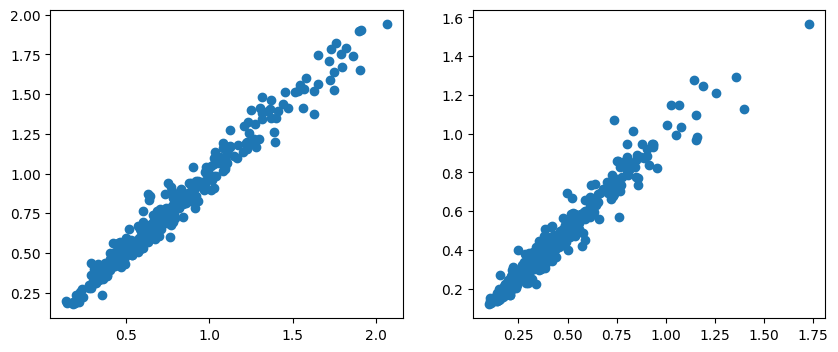

Results for Cbam:
  ew1: RMSE = 0.05900000035762787, r = 0.988
  ew2: RMSE = 0.052000001072883606, r = 0.977
  fwhm1: RMSE = 0.20100000500679016, r = 0.929
  fwhm2: RMSE = 0.20900000631809235, r = 0.915


In [24]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(test_data_435["true_ew1"],test_data_435["pre_ew1"])
ax2.scatter(test_data_435["true_ew2"],test_data_435["pre_ew2"])
plt.show()
if True:
    from sklearn.metrics import mean_squared_error, r2_score

    Cbam =test_data_435
    Cbam = Cbam[(Cbam["outputs"] > 0.5) & (Cbam["targets"] == 1)]


    def calculate_metrics(true_values, predicted_values):
        rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
        #r2 = r2_score(true_values, predicted_values)
        r2 = true_values.corr(predicted_values)
        return rmse, r2


    columns = ['ew1', 'ew2', 'fwhm1', 'fwhm2']
    results = {'Cbam': {}}

    for col in columns:
        true_col = f'true_{col}'
        pre_col = f'pre_{col}'
        
        rmse_cbam, r2_cbam = calculate_metrics(Cbam[true_col], Cbam[pre_col])
        results['Cbam'][col] = {'RMSE': round(rmse_cbam, 3), 'r': round(r2_cbam, 3)}
        
    for model, metrics in results.items():
        print(f"Results for {model}:")
        for col, values in metrics.items():
            print(f"  {col}: RMSE = {values['RMSE']}, r = {values['r']}")